# Calculate and plot meridional heat transport

## Uses two methods because of diagnostics available:
- From surface heat flux assuming steady state
- From temp_yflux_adv diagnostic (so does not include submeso or gm/diffusion if they are on)

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as cm

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata

print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
cc.start_cluster()

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 36185:127.0.0.1:36185 vdi-n19.nci.org.au -l rmh561


<Client: scheduler='tcp://127.0.0.1:45600' processes=4 cores=8>

In [7]:
# Infer from surface heat flux:
def find_MHF(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    #n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    shflux = cc.get_nc_variable(expt, 'ocean_month.nc', 'net_sfc_heating',
                          n=n_files, time_units = time_units, offset=offset, use_cache=True)
    shflux_am = shflux.mean('time').load()
    area = cc.get_nc_variable(expt, 'ocean_grid.nc','area_t',n=1, use_cache=True).mean('time').load()
    lat = cc.get_nc_variable(expt, 'ocean_grid.nc','geolat_t',n=1, use_cache=True).mean('time').load()
    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yt_ocean',n=1, use_cache=True).load()
    MHF = np.zeros_like(latv)
    for i in range(len(latv)):
        inds = lat < latv[i]
        MHF[i] = np.sum(area.where(lat < latv[i])*shflux_am.where(lat < latv[i]))

    MHF = MHF + (MHF[0]-MHF[-1])/2
    
    return latv, MHF

Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean_month.nc_net_sfc_heating_-12_days-since-1718-01-01_-87658_False.pkl


Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean_grid.nc_area_t_1_days-since-1900-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean_grid.nc_geolat_t_1_days-since-1900-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean_grid.nc_yt_ocean_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_ocean_month.nc_net_sfc_heating_-30_days-since-1718-01-01_-87658_False.pkl


Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_ocean_grid.nc_area_t_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_ocean_grid.nc_geolat_t_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_ocean_grid.nc_yt_ocean_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_month.nc_net_sfc_heating_None_None_None_False.pkl


Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_grid.nc_area_t_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_grid.nc_geolat_t_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_grid.nc_yt_ocean_1_days-since-1900-01-01_None_False.pkl


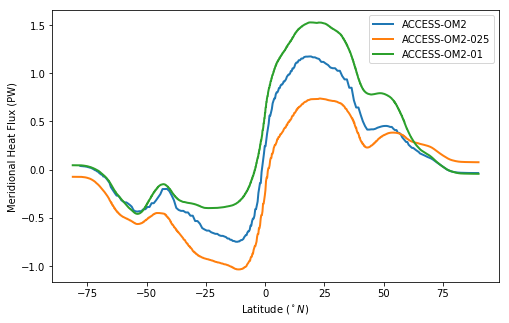

In [6]:
# Plot just surface heat flux inferred method:
fig = plt.figure(figsize=(8,5))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF(ekey)

    plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])

plt.legend()
savefigure('meridional_heat_transport')

In [8]:
# use temp_yflux_adv diagnostics:
def find_MHF_tempadv(ekey):
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    #n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    if (ekey == '01deg'):
        temp_yflux_adv = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_adv_int_z',
                                            n=n_files, time_units = time_units, offset=offset, use_cache=True)
        MHF = temp_yflux_adv.mean('time').sum('xt_ocean').load()
    else:
        temp_yflux_adv = cc.get_nc_variable(expt, 'ocean.nc', 'temp_yflux_adv',
                                            n=n_files, time_units = time_units, offset=offset, use_cache=True)
        MHF = temp_yflux_adv.mean('time').sum('st_ocean').sum('xt_ocean').load()

    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yu_ocean',n=1, use_cache=True).load()
    return latv, MHF

Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean_month.nc_net_sfc_heating_-12_days-since-1718-01-01_-87658_False.pkl


Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean_grid.nc_area_t_1_days-since-1900-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean_grid.nc_geolat_t_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean_grid.nc_yt_ocean_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean.nc_temp_yflux_adv_-12_days-since-1718-01-01_-87658_False.pkl


Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean_grid.nc_yu_ocean_1_days-since-1900-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_ocean_month.nc_net_sfc_heating_-30_days-since-1718-01-01_-87658_False.pkl


Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_ocean_grid.nc_area_t_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_ocean_grid.nc_geolat_t_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_ocean_grid.nc_yt_ocean_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_ocean.nc_temp_yflux_adv_-30_days-since-1718-01-01_-87658_False.pkl


Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_ocean_grid.nc_yu_ocean_1_days-since-1900-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_month.nc_net_sfc_heating_None_None_None_False.pkl


Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_grid.nc_area_t_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_grid.nc_geolat_t_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_grid.nc_yt_ocean_1_days-since-1900-01-01_None_False.pkl


Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_month.nc_temp_yflux_adv_int_z_None_None_None_False.pkl


Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_grid.nc_yu_ocean_1_days-since-1900-01-01_None_False.pkl


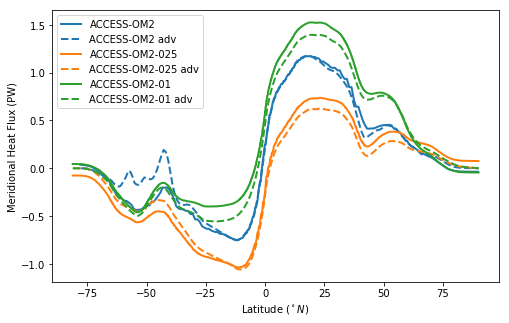

In [17]:
# plot both surface heat flux and temp_yflux_adv methods:
fig = plt.figure(figsize=(8,5))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF(ekey)
    latv_adv, MHF_adv = find_MHF_tempadv(ekey)

    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])
    plt.plot(latv_adv,MHF_adv/1.e15,'--',linewidth=2, label=exptdata.exptdict[ekey]['desc'] + ' adv',color=hand[0].get_color())

plt.legend()
savefigure('meridional_heat_transport_withadv')

In [4]:
cc.get_variables('01deg_jra55v13_iaf','ocean_month.nc')

['xt_ocean',
 'yt_ocean',
 'time',
 'nv',
 'xu_ocean',
 'yu_ocean',
 'sea_level',
 'eta_t',
 'sea_levelsq',
 'surface_temp',
 'surface_salt',
 'mld',
 'pme_river',
 'pme_net',
 'river',
 'runoff',
 'evap',
 'melt',
 'fprec',
 'lprec',
 'wfimelt',
 'wfiform',
 'sfc_salt_flux_restore',
 'sfc_salt_flux_ice',
 'sfc_salt_flux_coupler',
 'net_sfc_heating',
 'swflx',
 'lw_heat',
 'sens_heat',
 'evap_heat',
 'fprec_melt_heat',
 'sfc_hflux_from_runoff',
 'sfc_hflux_pme',
 'frazil_2d',
 'tau_x',
 'tau_y',
 'bmf_u',
 'bmf_v',
 'tx_trans_int_z',
 'ty_trans_int_z',
 'pbot_t',
 'temp_yflux_adv_int_z',
 'average_T1',
 'average_T2',
 'average_DT',
 'time_bounds']

In [6]:
 cc.get_variables('025deg_jra55v13_iaf','ocean_month.nc')

['xt_ocean',
 'yt_ocean',
 'time',
 'nv',
 'xu_ocean',
 'yu_ocean',
 'sea_level',
 'eta_t',
 'sea_levelsq',
 'mld',
 'pme_river',
 'river',
 'runoff',
 'ice_calving',
 'evap',
 'melt',
 'sfc_salt_flux_restore',
 'sfc_salt_flux_ice',
 'sfc_salt_flux_coupler',
 'net_sfc_heating',
 'tau_x',
 'tau_y',
 'bmf_u',
 'bmf_v',
 'tx_trans_int_z',
 'ty_trans_int_z',
 'average_T1',
 'average_T2',
 'average_DT',
 'time_bounds']